In [1]:
!git clone https://github.com/Akasxh/Terrain-Recognition.git

Cloning into 'Terrain-Recognition'...
remote: Enumerating objects: 28357, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 28357 (delta 93), reused 57 (delta 54), pack-reused 28250 (from 1)
Receiving objects: 100% (28357/28357), 1.33 GiB | 25.34 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (10541/10541), done.


In [2]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [3]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CyclicLR
import torch.nn as nn
import torch.optim as optim
from timm import create_model
from tqdm.auto import tqdm
import torch
from PIL import Image

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Define the directory paths (replace with your dataset paths)
train_dir = '/content/Terrain-Recognition/Data Main/Training Data'  # Training Data Path
test_dir = '/content/Terrain-Recognition/Data Main/Testing Data'  # Testing Data Path

# Define image transformations for training and testing
image_size = 224  # Size for MobileNetV2 input

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 224x224
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for MobileNetV2
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for MobileNetV2
])

# Create datasets and data loaders
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())

In [6]:
# Load Pre-trained MobileNetV2
model = models.mobilenet_v2(weights='DEFAULT')  # Load pre-trained weights

# Modify the last layer to fit your number of classes
num_classes = len(train_dataset.classes)  # Number of classes based on dataset
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 36.8MB/s]


In [7]:
# Print model summary
image_size = 224  # or your desired input size
# Print the summary of the model with input and output shapes per layer
summary(model,
        input_size=(32, 3, image_size, image_size),
        device=device,
        verbose=True,     # Enable verbose mode for detailed output
        col_names=["input_size", "output_size", "num_params", "trainable"])  # Specify columns to display

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
MobileNetV2                                        [32, 3, 224, 224]         [32, 5]                   --                        True
├─Sequential: 1-1                                  [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation: 2-1                   [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                            [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d: 3-2                       [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─ReLU6: 3-3                             [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─InvertedResidual: 2-2                       [32, 32,

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
MobileNetV2                                        [32, 3, 224, 224]         [32, 5]                   --                        True
├─Sequential: 1-1                                  [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation: 2-1                   [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                            [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d: 3-2                       [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─ReLU6: 3-3                             [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─InvertedResidual: 2-2                       [32, 32,

In [8]:
# Define loss function and optimizer with a lower learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)  # Initial learning rate for CyclicLR

# Define CyclicLR scheduler
scheduler = CyclicLR(
    optimizer,
    base_lr=0.0008,
    max_lr=0.001,
    step_size_up=2000,
    step_size_down=2000,
    mode='triangular2'
)

# Training and evaluation functions
def train_step(model, dataloader, loss_fn, optimizer, scheduler, device):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_acc += (y_pred.argmax(1) == y).sum().item() / len(y)
    return train_loss / len(dataloader), train_acc / len(dataloader)

def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            test_acc += (y_pred.argmax(1) == y).sum().item() / len(y)
    return test_loss / len(dataloader), test_acc / len(dataloader)

# Lists to store training and testing metrics
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Define the directory for saving the best model
best_model_dir = 'best_model_sg.pth'
best_accuracy = 0.0  # Variable to track the best accuracy

# Training loop
epochs = 6
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, scheduler, device)
    test_loss, test_acc = test_step(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Save model if it has the best accuracy so far
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), best_model_dir)
        print(f"  Model saved with Test Acc: {test_acc:.4f} (Best so far)")

# At the end of training, print the best accuracy
print(f"Best Test Accuracy: {best_accuracy:.4f}")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/6:
  Train Loss: 0.5878, Train Acc: 0.7930
  Test Loss: 0.4745, Test Acc: 0.8453
  Model saved with Test Acc: 0.8453 (Best so far)
Epoch 2/6:
  Train Loss: 0.4120, Train Acc: 0.8610
  Test Loss: 0.3498, Test Acc: 0.8871
  Model saved with Test Acc: 0.8871 (Best so far)
Epoch 3/6:
  Train Loss: 0.3483, Train Acc: 0.8795
  Test Loss: 0.3761, Test Acc: 0.8902
  Model saved with Test Acc: 0.8902 (Best so far)
Epoch 4/6:
  Train Loss: 0.2962, Train Acc: 0.8987
  Test Loss: 0.2719, Test Acc: 0.9133
  Model saved with Test Acc: 0.9133 (Best so far)
Epoch 5/6:
  Train Loss: 0.2706, Train Acc: 0.9062
  Test Loss: 0.4599, Test Acc: 0.8738
Epoch 6/6:
  Train Loss: 0.2518, Train Acc: 0.9127
  Test Loss: 0.3670, Test Acc: 0.8844
Best Test Accuracy: 0.9133


In [10]:
# Check model size
print(f'Model size: {os.path.getsize("/content/best_model_sg.pth") / 1e6:.2f} MB')  # Size in MB

Model size: 9.17 MB


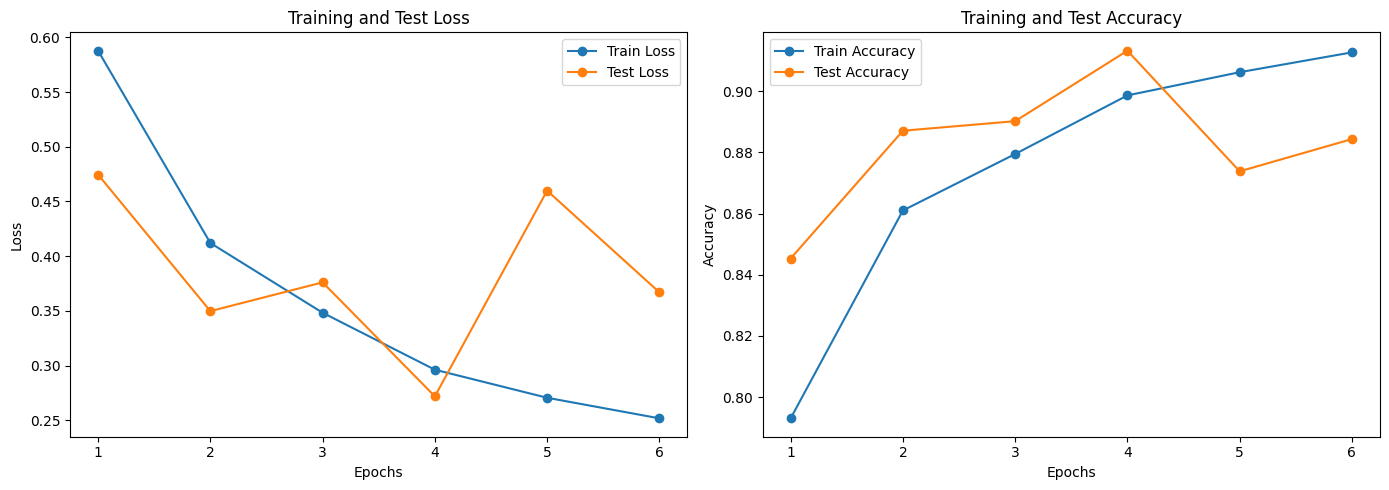

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Plotting
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 5))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, test_losses, label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


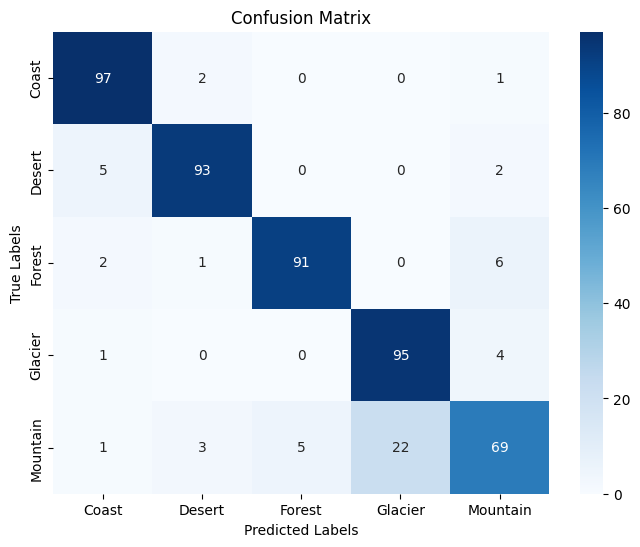

In [13]:
# After the training loop, compute and plot the confusion matrix
def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    # Collect all predictions and true labels
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            all_preds.extend(y_pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot using seaborn heatmap for better visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Define the class names for your dataset
class_names = train_dataset.classes

# Plot confusion matrix after all epochs
plot_confusion_matrix(model, test_loader, device, class_names)


In [14]:
# Load Pre-trained MobileNetV2
model = models.mobilenet_v2(weights='DEFAULT')  # Load pre-trained weights

# Modify the last layer to fit your number of classes
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Load the saved state dict
model.load_state_dict(torch.load('/content/best_model_sg.pth'))

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

<ipython-input-14-afd8bcff6241>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model_sg.pth'))


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

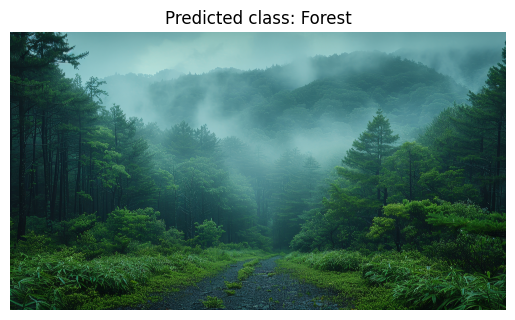

In [15]:
# Load and preprocess your custom image
image_path = '/content/beautiful-japanese-forest-scene.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
image_tensor = test_transform(image).unsqueeze(0)

model.to(device)
image_tensor = image_tensor.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(image_tensor)

_, predicted_class = torch.max(outputs, 1)

predicted_label = class_names[predicted_class.item()]

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title(f'Predicted class: {predicted_label}')
plt.show()

In [16]:
from google.colab import files

files.download('/content/best_model_sg.pth')  # For PyTorch model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>